In [ ]:
# THIS IS INITIALIZATION AND PARAMETERS SECTION.


import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
from matplotlib_venn import venn2
import sklearn
import sklearn.decomposition
from sklearn.preprocessing import StandardScaler
import seaborn as sns
from sklearn.manifold import TSNE
from pydeseq2 import dds, ds

# if you are reading this as PDF or HTML, the following value was set to 4.
pcs_count = int(input("input number of PCs needed in PCAs"))
# change this value to set palleete of plots.
palette = "tab10"

miR_data = pd.read_csv("miR.Counts.csv")
miR_data.set_index(miR_data["miRNA"], inplace=True)
miR_data.drop("miRNA", axis=1, inplace=True)
tRF_data = pd.read_csv("tRF.Counts.csv")
tRF_data.set_index(tRF_data["entry name"], inplace=True)
tRF_data.drop("entry name", axis=1, inplace=True)

# this is list of columns, containing data about examples with cysts.

cysts_list = {
    "1c_S43_R1_001": "mucinous",
    "7c_S44_R1_001": "mucinous",
    "32c_S45_R1_001": "mucinous",
    "4c_S46_R1_001": "serous",
    "6c_S47_R1_001": "serous",
    "34c_S48_R1_001": "serous",
}

mucinous_list = ["1c_S43_R1_001", "7c_S44_R1_001", "32c_S45_R1_001"]
serous_list = ["4c_S46_R1_001", "6c_S47_R1_001", "34c_S48_R1_001"]

# standardizing data
groups = [
    "no cyst" if i not in cysts_list.keys() else cysts_list[i] for i in miR_data.columns
]

# uncomment next line to see detailed information about exmaples with cysts
# groups = ["no cyst" if i not in cysts_list else i for i in miR_data.columns]

miR_data = miR_data.transpose()
tRF_data = tRF_data.transpose()
joined_data = miR_data.join(tRF_data)
scaler = StandardScaler()

cysts_only_df = joined_data.filter(list(cysts_list.keys()), axis=0)
cysts_only_std_df = scaler.fit_transform(cysts_only_df)
cyst_groups = [
    "mucinous",
    "mucinous",
    "mucinous",
    "serous",
    "serous",
    "serous",
]


# PCA of Cysts dataset

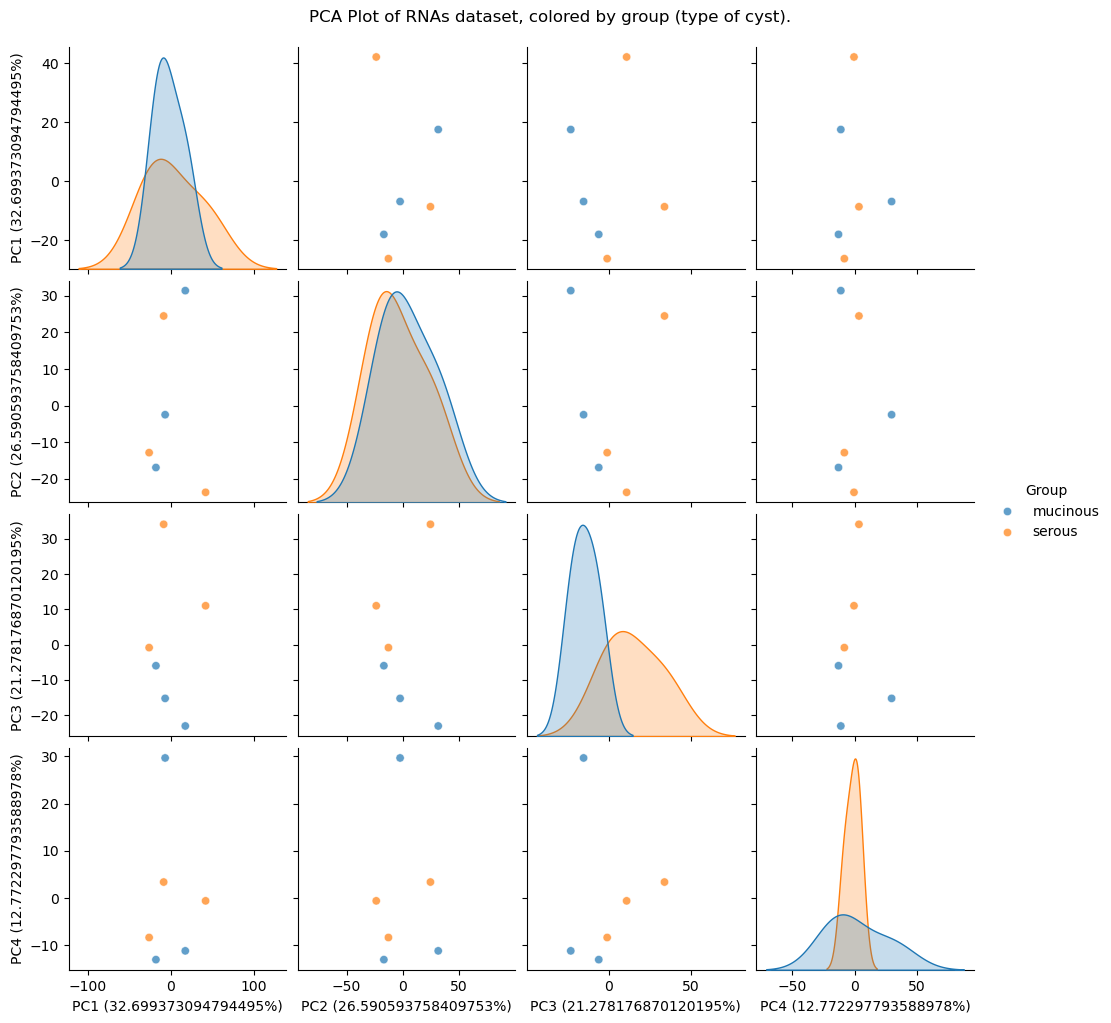

In [ ]:
PCA = sklearn.decomposition.PCA(pcs_count)
RNA_transformed = PCA.fit_transform(cysts_only_std_df)
RNA_explained_variance = PCA.explained_variance_
RNA_explained_variance_ratio = PCA.explained_variance_ratio_
RNA_pca_df = pd.DataFrame(
    {
        f"PC{i + 1} ({RNA_explained_variance_ratio[i] * 100}%)": RNA_transformed[:, i]
        for i in range(pcs_count)
    }
)
RNA_pca_df["Group"] = [cysts_list[i] for i in cysts_list]

sns.pairplot(
    data=RNA_pca_df,
    hue="Group",
    palette=palette,
    diag_kind="auto",
    plot_kws={"alpha": 0.7},
)
plt.suptitle("PCA Plot of RNAs dataset, colored by group (type of cyst).", y=1.02)
plt.show()


# Venn's diagrams of expressed RNAs: change parameter "RNA_count" to increase or decrease count of RNAs

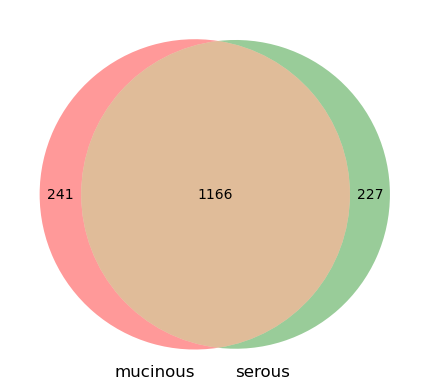

In [ ]:
RNA_count = 50

g1 = cysts_only_df.filter(mucinous_list, axis=0)
g2 = cysts_only_df.filter(serous_list, axis=0)

mucinous_rnas = set(g1.columns[(g1 > 0).any()])
serous_rnas = set(g2.columns[(g2 > 0).any()])

venn2((mucinous_rnas, serous_rnas), ("mucinous", "serous"))
plt.show()
unique_for_mucinous = mucinous_rnas - serous_rnas
unique_for_serous = serous_rnas - mucinous_rnas


# List of unique RNAs for mucinous group

In [ ]:
print("\n".join(unique_for_mucinous))


hsa-miR-4717-3p
hsa-miR-3144-3p
hsa-miR-2116-5p
hsa-miR-6829-5p
hsa-miR-7974
hsa-miR-1289-5p
hsa-miR-4768-5p
hsa-miR-19b-1-5p
Gln_Comb_23
hsa-miR-1537-5p
hsa-miR-2115-5p
hsa-miR-551a
hsa-miR-6732-5p
hsa-miR-3651
hsa-miR-216b-3p
hsa-miR-4666a-5p
hsa-miR-4671-5p
hsa-miR-655-3p
hsa-miR-656-3p
Thr_Comb_16
hsa-miR-619-5p
hsa-miR-663a-3p
hsa-miR-1185-1-3p/1185-2-3p
hsa-miR-10395-5p
hsa-miR-1248
hsa-miR-4703-3p
hsa-miR-432-3p
hsa-miR-4421
hsa-miR-1914-3p
hsa-miR-4636-5p
hsa-miR-3913-3p
hsa-miR-34b-3p
hsa-miR-376a-3p/376b-3p
hsa-miR-6749-3p
hsa-miR-516a-5p
hsa-miR-6824-3p
Glu_Comb_13
hsa-miR-3614-3p
hsa-miR-548t-5p
hsa-miR-4649-5p
hsa-miR-6506-5p
hsa-miR-3619-5p
hsa-miR-4497
hsa-miR-5571-3p
Pro_Comb_9
hsa-miR-6882-3p
hsa-miR-487b-5p
hsa-miR-3130-3p
hsa-miR-4708-3p
hsa-miR-556-5p
hsa-miR-4488
hsa-miR-4733-5p
hsa-miR-551b-3p
hsa-miR-549a-5p
hsa-miR-6501-3p
hsa-miR-1237-3p
hsa-miR-6503-5p
Arg_Comb_14
hsa-miR-4526-3p
hsa-miR-217-5p
Gln_Comb_16
hsa-miR-4753-3p
hsa-miR-4728-3p
hsa-miR-548ag-3p
Leu_C

# List of unique RNAs for serous group

In [ ]:
print("\n".join(unique_for_serous))


hsa-miR-4515
hsa-miR-4726-5p
hsa-miR-1908-3p
hsa-miR-1251-3p
hsa-miR-939-3p
hsa-miR-3145-3p
hsa-miR-4716-3p
hsa-miR-548ac
hsa-miR-135a-3p
hsa-miR-204-3p
Thr_Comb_24
hsa-miR-1226-5p
hsa-miR-7854-3p
hsa-miR-4771-5p
hsa-miR-548a-3p
hsa-miR-1908-5p
hsa-miR-1293-3p
hsa-miR-6509-5p
hsa-miR-503-3p
hsa-miR-3121-3p
hsa-miR-548ay-3p
hsa-miR-4723-3p
hsa-miR-5580-5p
hsa-miR-4690-3p
hsa-miR-6836-5p
hsa-miR-3177-5p
hsa-miR-767-3p
hsa-miR-6735-3p
hsa-miR-4790-3p
hsa-miR-6805-5p
Gln_Comb_13
hsa-miR-373-3p
hsa-miR-6720-5p
hsa-miR-597-3p
hsa-miR-6797-3p
hsa-miR-6873-3p
hsa-miR-4677-5p
hsa-miR-4790-5p
hsa-miR-3612
hsa-miR-602-5p
hsa-miR-615-5p
His_Comb_18
hsa-miR-122b-5p
hsa-miR-4758-3p
hsa-miR-6766-3p
hsa-miR-610
hsa-miR-4474-3p
hsa-miR-326-3p
hsa-miR-6726-3p
hsa-miR-6799-3p
hsa-miR-588-3p
Ala_Comb_20
hsa-miR-4783-3p
Ser_Comb_21
hsa-miR-6762-3p
hsa-miR-3191-5p
hsa-miR-3137
Trp_Comb_8
hsa-miR-3074-3p
hsa-miR-6877-3p
hsa-miR-6879-3p
hsa-miR-4799-5p
hsa-miR-6764-5p
hsa-miR-766-5p
hsa-miR-105-5p
hsa-miR-393

# tSNE analysis of cysts dataset. 

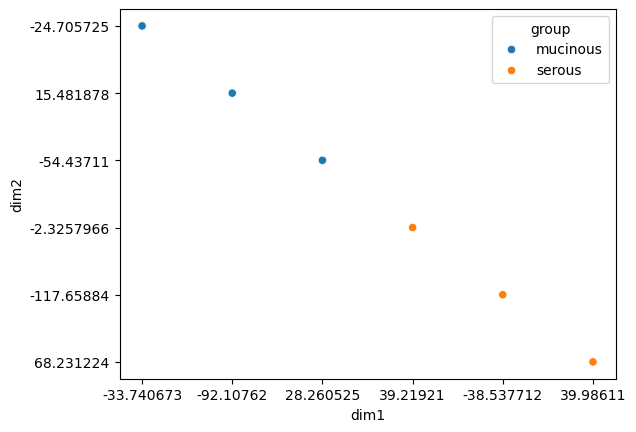

In [ ]:
tsne_cysts = np.vstack(
    (
        TSNE(n_components=2, perplexity=3, init="pca", learning_rate="auto")
        .fit_transform(cysts_only_std_df)
        .T,
        cyst_groups,
    )
).T

joined_df = pd.DataFrame(tsne_cysts, columns=("dim1", "dim2", "group"))

sns.scatterplot(data=joined_df, x="dim1", y="dim2", hue="group", palette=palette)
plt.show()


# Analysis with PyDeSeq2

In [ ]:
metadata = pd.DataFrame({"example": list(cysts_list.keys()), "condition": cyst_groups})
metadata.set_index(metadata["example"], inplace=True)
metadata.drop("example", axis=1, inplace=True)
dds_df = dds.DeseqDataSet(counts=cysts_only_df, metadata=metadata)
dds_df.deseq2()
ds_df = ds.DeseqStats(dds_df, alpha=0.05, cooks_filter=False, independent_filter=False)
ds_df.summary()
results = ds_df.results_df
results.dropna(inplace=True)
results.to_csv(open("DeSeqStats_results_no_NaNs.csv", "w"))


Fitting size factors...
... done in 0.00 seconds.

Fitting dispersions...
... done in 1.83 seconds.

Fitting dispersion trend curve...
... done in 0.09 seconds.

Fitting MAP dispersions...
... done in 1.74 seconds.

Fitting LFCs...
... done in 2.25 seconds.

Calculating cook's distance...
... done in 0.01 seconds.

Replacing 0 outlier genes.

Running Wald tests...


Log2 fold change & Wald test p-value: condition serous vs mucinous
                          baseMean  log2FoldChange     lfcSE      stat  \
hsa-let-7a-2-3p           0.395806       -1.899121  4.330989 -0.438496   
hsa-let-7a-3p            93.825792       -1.577305  1.612253 -0.978324   
hsa-let-7a-5p/7c-5p  243904.347711        1.244811  1.493580  0.833441   
hsa-let-7b-3p           168.613683       -2.606590  1.520194 -1.714643   
hsa-let-7b-5p         59143.187899        1.231111  1.426221  0.863198   
...                            ...             ...       ...       ...   
Glu_Comb_36              19.477912        3.116268  1.758328  1.772291   
Ser_Comb_29              21.198313        3.602308  1.689161  2.132602   
Gln_Comb_24               4.871116       -1.323243  2.119154 -0.624420   
Gln_Comb_25               0.000000             NaN       NaN       NaN   
Lys_Comb_28               0.000000             NaN       NaN       NaN   

                       pvalue      padj  
hs

... done in 0.73 seconds.

